# XGBoost Model

## Imports

In [1]:
# Preprocessing and encoding variables
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint

# Using Skicit-learn to split data into training and testing sets

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Import the classifier we are using
import xgboost as xgb
from xgboost import XGBClassifier

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Visualising feature importance and making plots
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score

In [2]:
G1 = pd.read_csv('../input/genomes-part1/G1.features.csv').iloc[:, 1:]
G2 = pd.read_csv('../input/genomes-part1/G2.features.csv').iloc[:, 1:]
G3 = pd.read_csv('../input/genomes-part1/G3.features.csv').iloc[:, 1:]
G4 = pd.read_csv('../input/genomes-part1/G4.features.csv').iloc[:, 1:]
G5 = pd.read_csv('../input/genomes-part1/G5.features.csv').iloc[:, 1:]
#G6 = pd.read_csv('../input/genomes/G6_translated.csv').iloc[:, 1:]
#G7 = pd.read_csv('../input/genomes/G7_translated.csv').iloc[:, 1:]
#G8 = pd.read_csv('../input/genomes/G8_translated.csv').iloc[:, 1:]
#G9 = pd.read_csv('../input/genomes/G9_translated.csv').iloc[:, 1:]
#G10 = pd.read_csv('../input/genomes/G10_translated.csv').iloc[:, 1:]
#G11 = pd.read_csv('../input/genomes/G11_translated.csv').iloc[:, 1:]
#G12 = pd.read_csv('../input/genomes/G12_translated.csv').iloc[:, 1:]
#G13 = pd.read_csv('../input/genomes/G13_translated.csv').iloc[:, 1:]
#G14 = pd.read_csv('../input/genomes/G14_translated.csv').iloc[:, 1:]
#G15 = pd.read_csv('../input/genomes/G15_translated.csv').iloc[:, 1:]

In [3]:
G1 = G1.sample(4000)
G2 = G2.sample(4000)
G3 = G3.sample(4000)
G4 = G4.sample(4000)
#G5 = G5.sample(4000)

In [4]:
frames = [G1, G2, G3, G4, G5]
G = pd.concat(frames)

#frames = [G1, G2, G3, G4, G5, G6, G7, G8, G9, G10]
#G = pd.concat(frames)

In [5]:
G = G.dropna()

In [6]:
G.tail(5)

,Type,Length,Dataset,Genome,GC_content,GC1_content,GC2_content,GC3_content,Start_ATG,Start_GTG,...,c_weight_TCG,c_weight_TCT,c_weight_TGA,c_weight_TGC,c_weight_TGG,c_weight_TGT,c_weight_TTA,c_weight_TTC,c_weight_TTG,c_weight_TTT
3661,CDS,4179,1,Campylobacter jejuni,0.369466,0.464465,0.307968,0.335966,1,0,...,0.104167,0.281250,0.0,0.535714,1,0.464286,0.304348,0.200000,0.267081,0.800000
3662,CDS,4245,1,Campylobacter jejuni,0.479152,0.582332,0.390813,0.464311,0,0,...,0.176471,0.161765,0.0,0.636364,1,0.363636,0.395833,0.323529,0.263889,0.676471
3663,CDS,4839,1,Campylobacter jejuni,0.397396,0.482331,0.376937,0.332920,1,0,...,0.118110,0.220472,0.0,0.266667,1,0.733333,0.349398,0.234375,0.259036,0.765625
3664,CDS,4881,1,Campylobacter jejuni,0.425118,0.539029,0.354640,0.381684,0,0,...,0.197531,0.111111,1.0,0.142857,1,0.857143,0.488372,0.194444,0.250000,0.805556
3665,LORF,5205,1,Campylobacter jejuni,0.394813,0.472622,0.357349,0.354467,1,0,...,0.176000,0.248000,1.0,0.432432,1,0.567568,0.308458,0.195402,0.203980,0.804598


In [7]:
print('The shape of our dataframe is:', G.shape)
print('Rows:', G.shape[0])
print('Columns:', G.shape[1])

The shape of our dataframe is: (19665, 14791)
Rows: 19665
Columns: 14791


## Preprocessing

### Encoding target variables

In [8]:
def encode_feature(array):
    """ Encode a categorical array into a number array
    
    :param array: array to be encoded
    :return: numerical array
    """
  
    encoder = preprocessing.LabelEncoder()
    encoder.fit(array)
    return encoder.transform(array)

In [9]:
class_names = ['CDS', 'LORF']
targets = G["Type"].values
print(targets)

['LORF' 'CDS' 'LORF' ... 'CDS' 'CDS' 'LORF']


In [10]:
targets = encode_feature(targets)
print(targets)

[1 0 1 ... 0 0 1]


In [11]:
print('The shape of our dataframe is:', G.shape)
print('Rows:', G.shape[0])
print('Columns:', G.shape[1])

The shape of our dataframe is: (19665, 14791)
Rows: 19665
Columns: 14791


### Selecting features and targets and converting data to arrays

In [12]:
# Labels are the values we want to predict
labels = targets

# Remove the labels from the features -> axis 1 refers to the columns
features = G.drop(['Type','Genome', 'Dataset'], axis = 1)

# Saving feature names as list for later use
feature_names = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [13]:
print('The shape of our features are:', features.shape)

The shape of our features are: (19665, 14788)


### Split into training and testing sets

In [14]:
# Split the data into training and testing sets -> x = features and y = labels/targets
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [15]:
print('Training Features Shape:', train_x.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing Labels Shape:', test_y.shape)

Training Features Shape: (14748, 14788)
Training Labels Shape: (14748,)
Testing Features Shape: (4917, 14788)
Testing Labels Shape: (4917,)


## Train model - default XGBoost

- **learning_rate**: step size shrinkage used to prevent overfitting. Range is [0,1]
- **max_depth**: determines how deeply each tree is allowed to grow during any boosting round.
- **subsample**: percentage of samples used per tree. Low value can lead to underfitting.
- **colsample_bytree**: percentage of features used per tree. High value can lead to overfitting.
- **n_estimators**: number of trees you want to build.
- **objective**: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability. XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

- **gamma**: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- **alpha**: L1 regularization on leaf weights. A large value leads to more regularization.
- **lambda**: L2 regularization on leaf weights and is smoother than L1 regularization.

In [16]:
# Create a Gaussian Classifier
xgb = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss', use_label_encoder=False)

# Train the model using the training sets 
xgb.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [17]:
# Make predictions for test data
y_pred = xgb.predict(test_x)

In [18]:
# Evaluate predictions
print("Accuracy score:", metrics.accuracy_score(test_y, y_pred))
# Precision, Recall and Roc_AUC score
print("Precision score:", metrics.precision_score(test_y, y_pred))
print("Recall score:", metrics.recall_score(test_y, y_pred))
#print("ROC_AUC score:", metrics.roc_auc_score(test_y, y_pred))

Accuracy score: 0.8863127923530608
Precision score: 0.8945845390657297
Recall score: 0.8768233387358185


### Confusion matrix

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


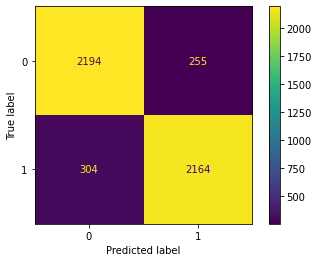

In [19]:
plot_confusion_matrix(xgb, test_x, test_y)  
plt.show()

#plt.savefig('confmatrix_g1_uneven.png', dpi=300, bbox_inches='tight', transparent=True)